In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Model
from tensorflow.keras.utils import img_to_array, load_img
from shutil import copyfile
from PIL import Image
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
print(tf.__version__)

2.12.0


In [3]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>=0.90):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [4]:
# Resized gambar agar memiliku jumlah pixel yang sama
def copy_to_working(path, new_path):
  for filename in os.scandir(path):
#     img = Image.open(os.path.join(path, filename.name))
#     img_resized= img.resize(new_size)
#     img_resized.save(os.path.join(new_path, filename.name))
    copyfile(os.path.join(path, filename.name), os.path.join(new_path, filename.name))

In [5]:
# Membuat direktori untuk menempatka data yang akan digunakan

resized_dir = '/kaggle/working/Resized_Dataset'
source_dir = '/kaggle/input/coffee-leaf-diseases'

if os.path.exists(resized_dir):
  shutil.rmtree(resized_dir)

def create_train_test_dirs(resized_path):
  os.mkdir(resized_path)
  os.mkdir(os.path.join(resized_path, 'train'))
  os.mkdir(os.path.join(resized_path, 'test'))

  for foldername in os.listdir(os.path.join(source_dir, 'train')):
    for i in os.listdir(resized_path):
      os.mkdir(os.path.join(resized_path, i, foldername))

try:
  create_train_test_dirs(resized_path=resized_dir)
except FileExistsError:
  print("File Sudah Ada")

In [6]:
# Train Source
train_miner_source = os.path.join(source_dir, 'train/miner/')
train_healthy_source = os.path.join(source_dir, 'train/nodisease/')
train_phoma_source = os.path.join(source_dir, 'train/phoma/')
train_rust_source = os.path.join(source_dir, 'train/rust/')

# Test Source
test_miner_source = os.path.join(source_dir, 'test/miner/')
test_healthy_source = os.path.join(source_dir, 'test/nodisease/')
test_phoma_source = os.path.join(source_dir, 'test/phoma/')
test_rust_source = os.path.join(source_dir, 'test/rust/')

# Train Resized
train_miner_resized = os.path.join(resized_dir, 'train/miner/')
train_healthy_resized = os.path.join(resized_dir, 'train/nodisease/')
train_phoma_resized = os.path.join(resized_dir, 'train/phoma/')
train_rust_resized = os.path.join(resized_dir, 'train/rust/')

# Test Resized
test_miner_resized = os.path.join(resized_dir, 'test/miner/')
test_healthy_resized = os.path.join(resized_dir, 'test/nodisease/')
test_phoma_resized = os.path.join(resized_dir, 'test/phoma/')
test_rust_resized = os.path.join(resized_dir, 'test/rust/')

In [7]:
# Melihat contoh ukuran dataset
sample_image  = load_img('/kaggle/input/coffee-leaf-diseases/train/phoma/16.jpg')
sample_array = img_to_array(sample_image)
print(f"Each image has shape: {sample_array.shape}")

sample_image  = load_img('/kaggle/input/coffee-leaf-diseases/test/phoma/500.jpg')
sample_array = img_to_array(sample_image)
print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (1024, 2048, 3)
Each image has shape: (1024, 2048, 3)


In [8]:
train_source_list = [train_miner_source, train_healthy_source, train_phoma_source, train_rust_source]
test_source_list = [test_miner_source, test_healthy_source, test_phoma_source, test_rust_source]
train_resized_list = [train_miner_resized, train_healthy_resized, train_phoma_resized, train_rust_resized]
test_resized_list = [test_miner_resized, test_healthy_resized, test_phoma_resized, test_rust_resized]

for train in train_source_list:
    for resized in train_resized_list:
        if train_source_list.index(train) == train_resized_list.index(resized):
          copy_to_working(train, resized)
        
for test in test_source_list:
    for resized in test_resized_list:
        if test_source_list.index(test) == test_resized_list.index(resized):
          copy_to_working(test, resized)

In [9]:
# # Jumlah gambar yang ingin tersisa di setiap folder
# train_jumlah_tersisa = 280
# test_jumlah_tersisa = 60

# for folder in train_resized_list:
#     # Dapatkan daftar semua file gambar dalam folder
#     gambar = [file for file in os.listdir(folder) if file.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

#     # Pastikan jumlah gambar yang ingin tersisa tidak melebihi jumlah gambar yang ada
#     jumlah_tersisa = min(train_jumlah_tersisa, len(gambar))

#     # Jumlah gambar yang akan dihapus
#     jumlah_hapus = len(gambar) - train_jumlah_tersisa

#     # Acak urutan gambar
#     random.shuffle(gambar)

#     # Hapus gambar secara acak sampai tersisa jumlah tertentu
#     for i in range(jumlah_hapus):
#         file = os.path.join(folder, gambar[i])
#         os.remove(file)
        
# for folder in test_resized_list:
#     # Dapatkan daftar semua file gambar dalam folder
#     gambar = [file for file in os.listdir(folder) if file.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

#     # Pastikan jumlah gambar yang ingin tersisa tidak melebihi jumlah gambar yang ada
#     jumlah_tersisa = min(test_jumlah_tersisa, len(gambar))

#     # Jumlah gambar yang akan dihapus
#     jumlah_hapus = len(gambar) - test_jumlah_tersisa

#     # Acak urutan gambar
#     random.shuffle(gambar)

#     # Hapus gambar secara acak sampai tersisa jumlah tertentu
#     for i in range(jumlah_hapus):
#         file = os.path.join(folder, gambar[i])
#         os.remove(file)

# print('Penghapusan selesai.')

In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tentukan path folder train dan test
train_dir = '/kaggle/input/coffee-leaf-diseases/train'
test_dir = '/kaggle/input/coffee-leaf-diseases/test'
# train_dir = '/kaggle/working/Resized_Dataset/train'
# test_dir = '/kaggle/working/Resized_Dataset/test'

# Tentukan dimensi gambar yang diharapkan
input_shape = (224, 224)

# Load dataset train menjadi array numpy
train_images = []
train_labels = []
val_images = []
val_labels = []
classes = ['miner', 'nodisease', 'phoma', 'rust']
for class_index, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
#         image = tf.keras.preprocessing.image.load_img(image_path, target_size=input_shape)
#         image_array = tf.keras.preprocessing.image.img_to_array(image)
        img = Image.open(image_path).convert('RGB')
        img = img.resize((300, 300 * img.size[1] // img.size[0]), Image.Resampling.LANCZOS)
        inp_numpy = np.array(img)[None]
        image_array = tf.constant(inp_numpy, dtype='float32')
        train_images.append(image_array)
        train_labels.append(class_index)
    class_dir = os.path.join(test_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
#         image = tf.keras.preprocessing.image.load_img(image_path, target_size=input_shape)
#         image_array = tf.keras.preprocessing.image.img_to_array(image)
        img = Image.open(image_path).convert('RGB')
        img = img.resize((300, 300 * img.size[1] // img.size[0]), Image.Resampling.LANCZOS)
        inp_numpy = np.array(img)[None]
        image_array = tf.constant(inp_numpy, dtype='float32')
        val_images.append(image_array)
        val_labels.append(class_index)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Konversi dataset train menjadi tf.constant
# train_images = tf.constant(train_images, dtype=tf.float32)
# train_labels = tf.constant(train_labels, dtype=tf.int32)
# val_images = tf.constant(val_images, dtype=tf.float32)
# val_labels = tf.constant(val_labels, dtype=tf.int32)
train_images = tf.constant(np.squeeze(train_images), dtype=tf.float32)
train_labels = tf.constant(train_labels, dtype=tf.int32)
val_images = tf.constant(np.squeeze(val_images), dtype=tf.float32)
val_labels = tf.constant(val_labels, dtype=tf.int32)

In [11]:
print(train_images[0])

tf.Tensor(
[[[207. 205. 206.]
  [207. 205. 206.]
  [208. 206. 207.]
  ...
  [223. 221. 221.]
  [219. 218. 216.]
  [219. 218. 216.]]

 [[210. 208. 209.]
  [211. 209. 210.]
  [211. 209. 210.]
  ...
  [221. 220. 220.]
  [219. 218. 216.]
  [218. 217. 215.]]

 [[212. 210. 211.]
  [212. 210. 211.]
  [212. 210. 211.]
  ...
  [220. 218. 217.]
  [220. 217. 216.]
  [219. 216. 215.]]

 ...

 [[220. 218. 219.]
  [220. 218. 219.]
  [220. 218. 219.]
  ...
  [222. 218. 217.]
  [223. 219. 218.]
  [222. 218. 217.]]

 [[220. 218. 219.]
  [221. 219. 220.]
  [221. 219. 220.]
  ...
  [222. 218. 217.]
  [222. 218. 217.]
  [222. 218. 217.]]

 [[219. 217. 218.]
  [220. 218. 219.]
  [220. 218. 219.]
  ...
  [221. 217. 216.]
  [222. 218. 217.]
  [222. 218. 217.]]], shape=(150, 300, 3), dtype=float32)


In [12]:
# Buat model untuk melatih data
ResNet = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(150, 300, 3),
)

for layer in ResNet.layers:
    layer.trainable = False


x = tf.keras.layers.Flatten()(ResNet.output)
# x = tf.keras.layers.Dense(64, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4, activation='softmax')(x)

model = Model(ResNet.input, x)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 306, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 150, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization

In [18]:
history = model.fit(train_images,
                    train_labels,
                    epochs=25,
                    verbose=1,
                    validation_data=(val_images, val_labels)
                   )

Epoch 1/25
40/40 [==============================] - 5s 129ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3239 - val_accuracy: 0.9000
Epoch 2/25
40/40 [==============================] - 5s 131ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.3248 - val_accuracy: 0.9000
Epoch 3/25
40/40 [==============================] - 5s 129ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.3280 - val_accuracy: 0.9000
Epoch 4/25
40/40 [==============================] - 5s 128ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3175 - val_accuracy: 0.9000
Epoch 5/25
40/40 [==============================] - 5s 129ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3217 - val_accuracy: 0.9000
Epoch 6/25
40/40 [==============================] - 5s 131ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3268 - val_accuracy: 0.9000
Epoch 7/25
40/40 [==============================] - 5s 131ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.3216 - val_accuracy: 0.9000
Epoch 

In [19]:
model.evaluate(val_images, val_labels)

13/13 [==============================] - 1s 93ms/step - loss: 0.3321 - accuracy: 0.9025


[0.3321298360824585, 0.9024999737739563]

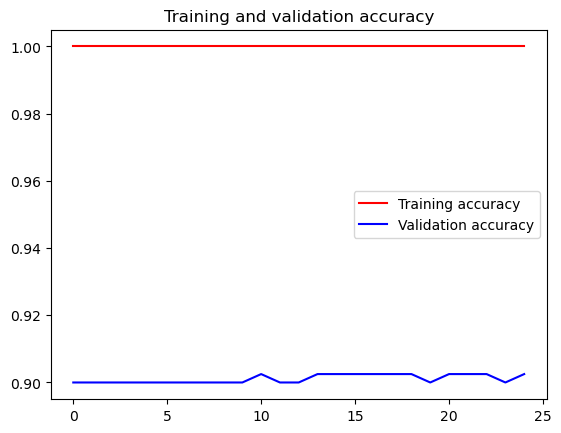

<Figure size 640x480 with 0 Axes>

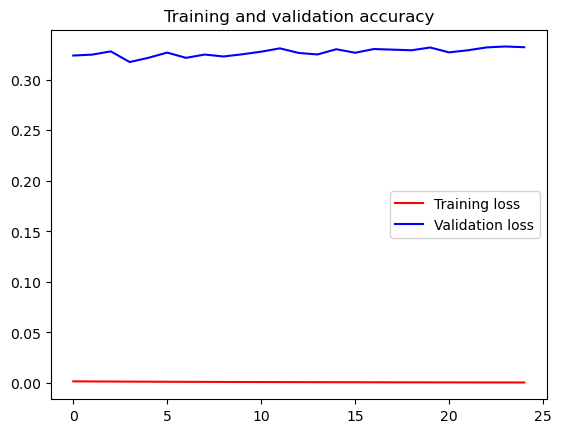

<Figure size 640x480 with 0 Axes>

13/13 [==============================] - 1s 93ms/step


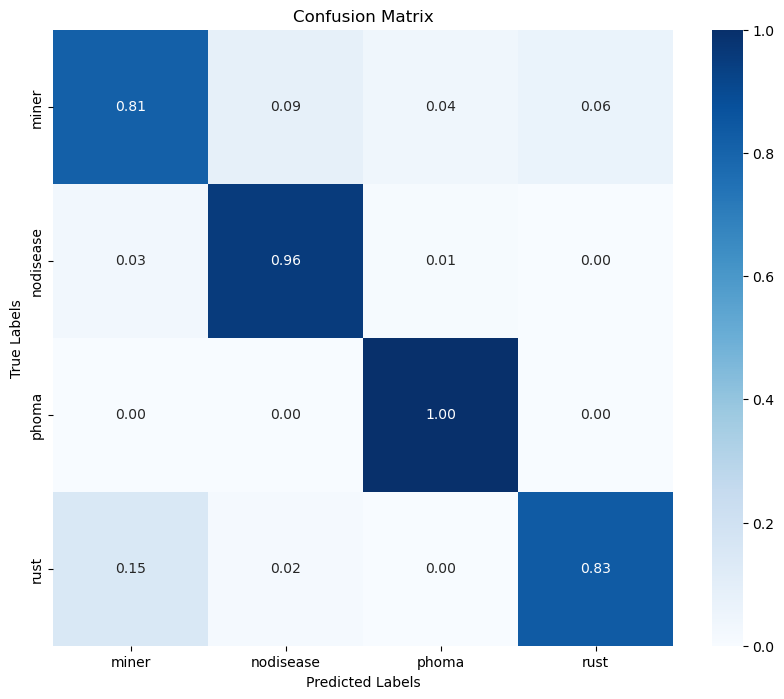

In [20]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Train and Validation Accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

#Train and Validation Loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

# Confusion Matrix Heatmap
# class_labels = sorted(os.listdir('/kaggle/input/coffee-leaf-diseases/train'))
predictions = model.predict(val_images)
predicted_labels = np.argmax(predictions, axis=1)
# true_labels = val_generator.classes
cm = confusion_matrix(val_labels, predicted_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
prediksi = model.predict(val_images)
y_pred = np.argmax(prediksi, axis=1)
# y_true = val_generator.labels

print(classification_report(val_labels, y_pred))

13/13 [==============================] - 1s 93ms/step
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       128
           1       0.90      0.96      0.93       116
           2       0.94      1.00      0.97        96
           3       0.86      0.83      0.85        60

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



In [22]:
# Save model dengan fromat HDF5
model.save('Coffee_disease_ResNet.h5')
my_model = tf.keras.models.load_model('Coffee_disease_ResNet.h5')

# convert model ke TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
tflite_model = converter.convert()

# save TFLite model
with open('Coffee_disease_ResNet.tflite', 'wb') as f:
  f.write(tflite_model)